In [620]:
#1. Data Import + Basic Cleaning + Username/Date Prep

In [621]:
#a one off step, leaving in for reference
!pip install emoji

In [622]:
#step 1 - import the pandas library to work with the csv dataset, numpy for numerical operations, 
#regular expressions for pattern matching, emoji for emoji-related features and Standard Scaler for feature scaling
import pandas as pd
import numpy as np
import re
import emoji
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

#step 2 - load the csv file with tweets
df = pd.read_csv("Tweets.csv")

#step 3 - show the first 5 rows to preview the data
print(df.head())

   id                                               link  \
0   0  https://twitter.com/HackneyPSC/status/17274436...   
1   1  https://twitter.com/cherrysattitude/status/172...   
2   2  https://twitter.com/diamoundgirls2/status/1710...   
3   3  https://twitter.com/mmtchi/status/172764634165...   
4   4  https://twitter.com/NoahIeeNG/status/172744319...   

                                                text              date  likes  \
0  A statement from psychoanalytic activists:  Th...  11/22/2023 21:47      0   
1                        bak bak bak bak doyamadınız  11/22/2023 15:27    443   
2  Check out 🏒 35 + different ERIK KARLSSON cards...    10/7/2023 7:15      0   
3  Il s'en passe des trucs pendant qu'on vous ori...  11/23/2023 11:12    381   
4  AW OKAY.. WELL THATS COOL, IM SURE PAL WILL AP...  11/22/2023 21:45      0   

   comments  
0         0  
1         9  
2         0  
3        44  
4         0  


In [623]:
#step 4 - extract usernames from the tweet link
#the username is always the fourth part after the third "/"
def extract_username(link):
    try:
        return link.split("/")[3] #this gets the username
    except:
        return None #if the link is missing or broken, this returns nothing

df['username'] = df['link'].apply(extract_username)

In [624]:
#step 5 - convert the 'date' column to datetime format needed for timeline features 
df['date'] = pd.to_datetime(df['date'], errors='coerce') #errors='coerce' deals with bad data

#step 6 - drop empty rows
df.dropna(how='all', inplace=True)

In [625]:
#step 7 - print basic info to see how many columns and rows are present
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15498 entries, 0 to 15497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        15498 non-null  int64         
 1   link      15498 non-null  object        
 2   text      15470 non-null  object        
 3   date      15498 non-null  datetime64[ns]
 4   likes     15498 non-null  int64         
 5   comments  15498 non-null  int64         
 6   username  15498 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 847.7+ KB
None


In [626]:
#2. Feature Extraction

In [627]:
#step 1 - count how many tweets each user posted
tweet_count = df['username'].value_counts().rename_axis('username').reset_index(name='tweet_count')

In [628]:
#step 2 - sort tweets by user and date to calculate the gap between tweets
df_sorted = df.sort_values(by=['username', 'date'])
df_sorted['time_difference'] = df_sorted.groupby('username')['date'].diff().dt.total_seconds()

In [629]:
#step 3 - calculolate average time between tweets for each user in  minutes
average_time_between =  df_sorted.groupby('username')['time_difference'].mean().fillna(0)
average_time_between_minutes = (average_time_between / 60).rename('average_time_between_tweets_minutes')

In [630]:
#step 4 - check how many tweets are written in 50% >= all caps
def is_majority_all_caps(text):
    try:
        words = text. split()
        if not words:
            return False
        return sum(words.isupper() for word in words) / len(words) > 0.5
    except:
        return False

percentage_all_caps = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([is_majority_all_caps(t) for t in tweets])
).rename('percentage_of_tweets_with_all_caps')

In [631]:
#step 5 - count average number of emojis in each tweet
def count_emojis(text):
    if not isinstance(text, str):
        return 0 
    return sum (1 for c in text if c in emoji.EMOJI_DATA)

average_emoji_count = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_emojis(t) for t in tweets])
).rename('average_emoji_count_per_tweet')

In [632]:
#step 6 - track emotionally intense language using a lexicon
emotional_words = set()
target_emotions = {'anger', 'fear', 'disgust', 'sadness', 'negative'}

with open("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split("\t")
        if len(parts) ==3:
            word, emotion, assoc = parts
            if assoc =='1' and emotion in target_emotions:
                emotional_words.add(word)

def count_emotional_words(text):
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(word in emotional_words for word in words)

average_emotion_words = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_emotional_words(t) for t in tweets])
).rename('average_emotionally_charged_words_per_tweet')

In [633]:
#step 7 - calculate tweet length average per user
average_tweet_length = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([len(str(t)) for t in tweets])
).rename('average_tweet_length')

In [634]:
#step 8 - count average number of hashtags per tweet 
def count_hashtags(text):
    return len(re.findall(r'#\w+', str(text)))

average_hashtags = df.groupby('username')['text'].apply(
    lambda tweets: np.mean([count_hashtags(t) for t in tweets])
).rename('average_hashtag_frequency_per_tweet')

In [635]:
#step 9 - set tweet count index to match others
tweet_count = tweet_count.set_index('username')

In [636]:
#step 10 - combine all features coded until now into one dataset
feature_matrix = pd.concat([
    tweet_count,
    average_time_between_minutes,
    percentage_all_caps,
    average_emoji_count,
    average_emotion_words,
    average_tweet_length,
    average_hashtags
], axis=1)

In [637]:
#step 10a - adding tweet length cap as this distorted the plot with outliers being too far from the centroid
feature_matrix['average_tweet_length'] = feature_matrix['average_tweet_length'].clip(upper=1000)

In [638]:
#step 11 - chech the final result
print(feature_matrix.head())

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique                 84                            45.156627   
salusalemchalom           48                             5.851064   
Kuwait_KW01               38                           102.054054   
diamoundgirls2            37                            27.305556   
AvivaKlompas              31                           958.433333   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusalemchalom                                 0.0   
Kuwait_KW01                                     0.0   
diamoundgirls2                                  0.0   
AvivaKlompas                                    0.0   

                 average_emoji_count_per_tweet  \
username                                         
Novytique                     

In [639]:
#3. Feature Scaling

In [640]:
#step 1 - use StandardScaler to normalise all values so they are similar in range
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

In [641]:
#step 2 - convert back to dataframe so we can still see column names
scaled_df = pd.DataFrame(scaled_features, columns=feature_matrix.columns, index=feature_matrix.index)

In [642]:
#step 3 - check the final scaled values
print(scaled_df.head())

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique          46.443893                            -0.038475   
salusalemchalom    26.189500                            -0.040856   
Kuwait_KW01        20.563280                            -0.035029   
diamoundgirls2     20.000658                            -0.039557   
AvivaKlompas       16.624925                             0.016839   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusalemchalom                                 0.0   
Kuwait_KW01                                     0.0   
diamoundgirls2                                  0.0   
AvivaKlompas                                    0.0   

                 average_emoji_count_per_tweet  \
username                                         
Novytique                     

In [643]:
#4. KMeans clustering

In [644]:
#step 1 - import kmeans and silhouette score from sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [645]:
#step 2 - decide how many clusters to try (as of now, we will try 2 to 10)
k_range = range(2, 11)
scores = []

In [646]:
#step 3 - loop through each k and calculate the silhouette score
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    scores.append(score)
    print(f"k = {k}, silhouette score = {score:.2f}")

k = 2, silhouette score = 0.67
k = 3, silhouette score = 0.73
k = 4, silhouette score = 0.30
k = 5, silhouette score = 0.30
k = 6, silhouette score = 0.30
k = 7, silhouette score = 0.33
k = 8, silhouette score = 0.34
k = 9, silhouette score = 0.32
k = 10, silhouette score = 0.32


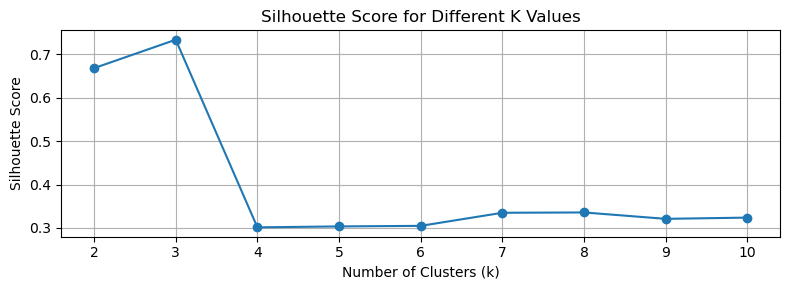

In [647]:
#step 4 - plot the silhouette scores to find the best k 
plt.figure(figsize=(8, 3))
plt.plot(k_range, scores, marker='o')
plt.title("Silhouette Score for Different K Values")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [648]:
#step 5 - choose the best k based on the plot
best_k = 3 #this has changed due to adjustments to lexicon
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(scaled_df)

In [649]:
#step 6 - add the cluster labels back to the feature matrix and df
feature_matrix['cluster'] = cluster_labels
df = df.merge(feature_matrix['cluster'], left_on='username', right_index=True, how='left')

In [650]:
#step 7 - check how many users are in each cluster
print(feature_matrix['cluster'].value_counts())

cluster
0    10329
1      237
2      115
Name: count, dtype: int64


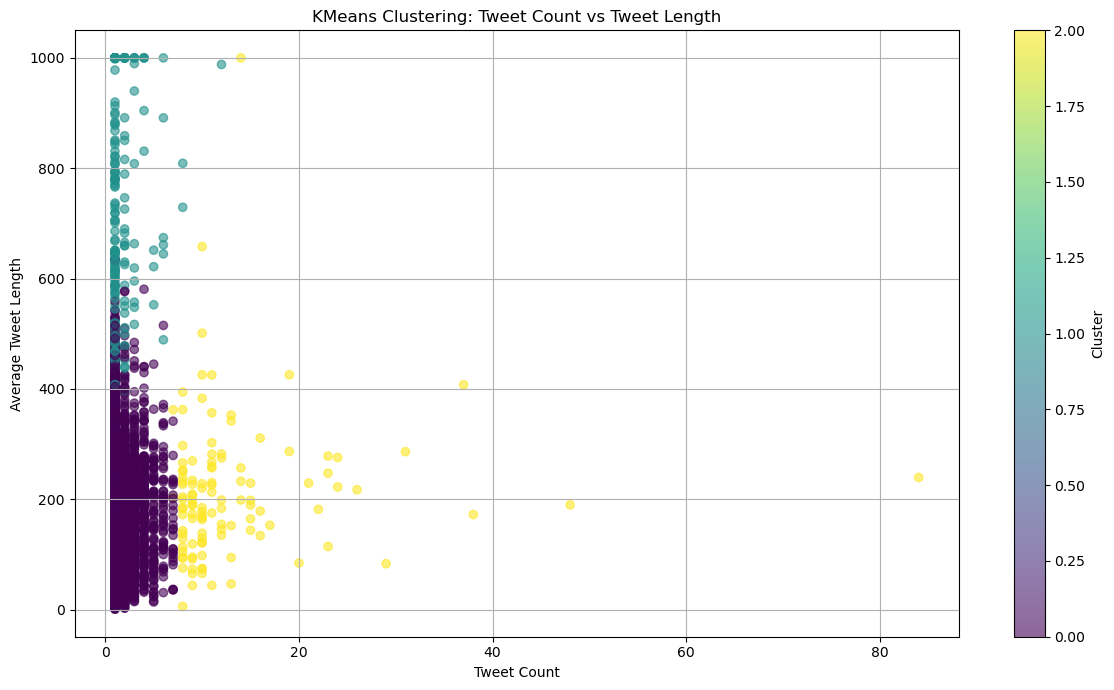

In [651]:
#step 8 - visualise the clusters in 2D using tweet count vs tweet lenght 
plt.figure(figsize=(12, 7))
plt.scatter(
    feature_matrix['tweet_count'],
    feature_matrix['average_tweet_length'],
    c=feature_matrix['cluster'],
    cmap='viridis',
    alpha=0.6
)
plt.xlabel("Tweet Count")
plt.ylabel("Average Tweet Length")
plt.title("KMeans Clustering: Tweet Count vs Tweet Length")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [652]:
#step 9 - create a new column to represent the week of each tweet
df['week'] = df['date'].dt.to_period('W').astype(str) #this formats each date tinto a weekly bracket

In [653]:
#step 10 - define helper functions for features
def is_majority_all_caps(text):
    try:
        words = text.split()
        if not words:
            return False
        return sum(word.isupper() for word in words) / len(words) > 0.5
    except:
        return False

def count_emojis(text):
    if not isinstance(text, str):
        return 0
    return sum(1 for c in text if c in emoji.EMOJI_DATA)

def count_emotional_words(text):
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(word in emotional_words for word in words)

def count_hashtags(text):
    return len(re.findall(r'#\w+', str(text)))

In [654]:
#step 11 - calculate weekly feature values per user
weekly_metrics = df.groupby(['username', 'week']).agg(
    weekly_tweet_count=('text', 'count'),
    total_caps_tweets=('text', lambda tweets: sum(is_majority_all_caps(t) for t in tweets)),
    total_emojis=('text', lambda tweets: sum(count_emojis(t) for t in tweets)),
    total_emotional_words=('text', lambda tweets: sum(count_emotional_words(t) for t in tweets)),
    total_hashtags=('text', lambda tweets: sum(count_hashtags(t) for t in tweets)),
    average_tweet_length=('text', lambda tweets: np.mean([len(str(t)) for t in tweets])),
    average_time_between_tweets_minutes=('date', lambda dates: dates.sort_values().diff().dt.total_seconds().mean() / 60 if len(dates) > 1 else 0)
).reset_index()

In [655]:
#step 12 - preview the restult
print(weekly_metrics.head())

      username                   week  weekly_tweet_count  total_caps_tweets  \
0    001Flight  2023-12-11/2023-12-17                   1                  0   
1    0130Coach  2023-12-11/2023-12-17                   1                  0   
2       01IOTA  2023-12-11/2023-12-17                   1                  0   
3  021Scenario  2023-12-11/2023-12-17                   1                  0   
4        06Kiu  2023-11-20/2023-11-26                   1                  0   

   total_emojis  total_emotional_words  total_hashtags  average_tweet_length  \
0             0                      1               0                  63.0   
1             0                      8               0                 453.0   
2             0                      2               0                 280.0   
3             0                      0               0                  40.0   
4             0                      0               0                  73.0   

   average_time_between_tweets_minutes

In [656]:
#step 13 - calculate change in weekly behaviour for each user
#this step checks how did user's behaviour shift from one week to the next
weekly_metrics = weekly_metrics.sort_values(['username', 'week'])

#group by user and calculaate week-to-week difference for key features
diff_columns = ['weekly_tweet_count', 'total_caps_tweets', 'total_emojis', 'total_emotional_words', 'total_hashtags', 'average_tweet_length']
weekly_metrics_diff = weekly_metrics.groupby('username')[diff_columns].diff().abs()

#sum all differences per user to get a single score
weekly_metrics['behaviour_change_score'] = weekly_metrics_diff.sum(axis=1)

In [657]:
#step 14 - preview users with the biggest changes
most_spiky = weekly_metrics.sort_values('behaviour_change_score', ascending=False).head(10)
print(most_spiky[['username', 'week', 'behaviour_change_score'] + diff_columns])

            username                   week  behaviour_change_score  \
5550   SimyBenarroch  2023-12-11/2023-12-17                  3549.0   
8401           hhezi  2023-12-11/2023-12-17                  3493.0   
2297        GeopolPt  2023-12-11/2023-12-17                  2664.5   
10739   thehoffather  2023-12-11/2023-12-17                  2215.4   
7106        bdnews24  2023-12-11/2023-12-17                  1371.0   
7604       dani86873  2023-12-11/2023-12-17                  1322.5   
2281    GazaNewsPlus  2023-12-04/2023-12-10                  1221.0   
8830   julienbahloul  2023-12-11/2023-12-17                  1179.0   
7321          caitoz  2023-12-11/2023-12-17                  1138.0   
5128   RnaudBertrand  2023-12-04/2023-12-10                  1070.5   

       weekly_tweet_count  total_caps_tweets  total_emojis  \
5550                    1                  0             1   
8401                    1                  0             0   
2297                    2       

In [658]:
#step 15 - define clusters to match users with behavioural spikes
cluster_summary = feature_matrix.groupby('cluster').mean()
print(cluster_summary)

         tweet_count  average_time_between_tweets_minutes  \
cluster                                                     
0           1.316197                           445.628449   
1           1.603376                          2518.739238   
2          13.243478                         17978.982741   

         percentage_of_tweets_with_all_caps  average_emoji_count_per_tweet  \
cluster                                                                      
0                                       0.0                       0.241752   
1                                       0.0                       1.710619   
2                                       0.0                       0.360532   

         average_emotionally_charged_words_per_tweet  average_tweet_length  \
cluster                                                                      
0                                           1.256281            168.821964   
1                                           8.934564            731.9

In [659]:
#step 16 - users with the most spikes
most_spiky_clusters = df[df['username'].isin(most_spiky['username'])][['username', 'cluster']].drop_duplicates()
print(most_spiky_clusters)

           username  cluster
158        bdnews24        1
245   RnaudBertrand        1
678   julienbahloul        1
1318         caitoz        1
1884       GeopolPt        1
2778          hhezi        1
2902  SimyBenarroch        1
3464   thehoffather        1
4480   GazaNewsPlus        1
9717      dani86873        1


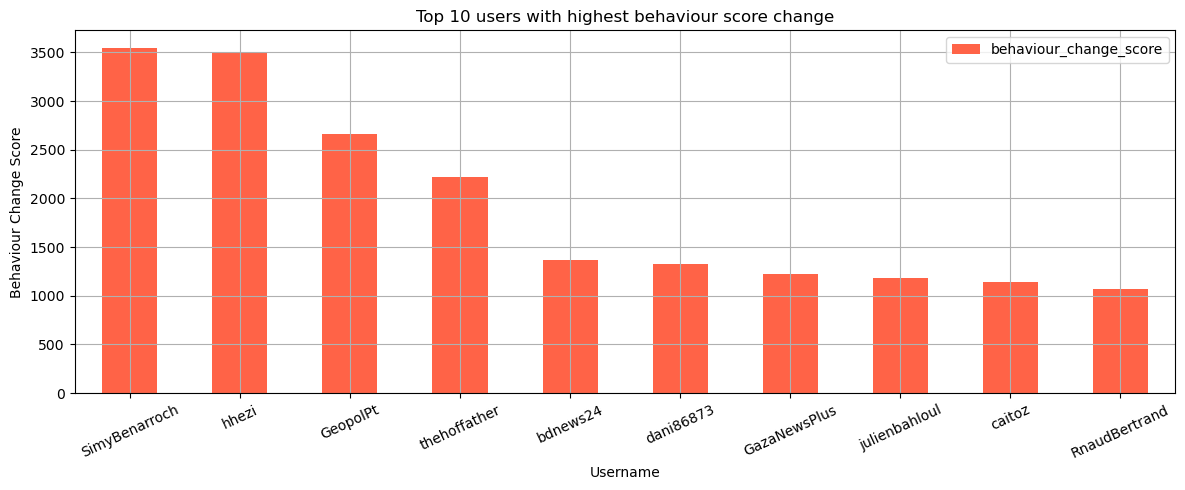

In [660]:
#step 17 - Bar Plot of behaviour score
most_spiky.plot(
    x='username',
    y='behaviour_change_score',
    kind='bar',
    figsize=(12, 5),
    color='tomato'
)

plt.title("Top 10 users with highest behaviour score change")
plt.ylabel("Behaviour Change Score")
plt.xlabel("Username")
plt.xticks(rotation=25)
plt.tight_layout()
plt.grid(True)
plt.show()

In [661]:
#5. DBSCAN Clustering

In [662]:
#step 1 - apply DBSCAN clustering to the scaled features
dbscan = DBSCAN(eps=1.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_df)

In [663]:
#step 2 - assign DBSCAN labels back to the dataframe
feature_matrix['dbscan_cluster'] = dbscan_labels
df = df.merge(feature_matrix['dbscan_cluster'], left_on='username', right_index=True, how='left')

In [664]:
#step 3 - check how many clusters and outliers are found
print("DBSCAN labels count:")
print(feature_matrix['dbscan_cluster'].value_counts())

DBSCAN labels count:
dbscan_cluster
 1    10519
-1      151
 2        6
 0        5
Name: count, dtype: int64


In [665]:
#step 4 - outlier (-1) preview
outliers = feature_matrix[feature_matrix['dbscan_cluster'] == -1]
print(outliers.sort_values(by='tweet_count', ascending=False).head(10))

                 tweet_count  average_time_between_tweets_minutes  \
username                                                            
Novytique                 84                            45.156627   
salusalemchalom           48                             5.851064   
Kuwait_KW01               38                           102.054054   
diamoundgirls2            37                            27.305556   
AvivaKlompas              31                           958.433333   
jacksonhinklle            29                          2059.000000   
EviesSantiago             26                          1155.280000   
everydropoftear           24                            15.260870   
MaxChar13                 23                            11.727273   
EPLPeter                  20                             1.263158   

                 percentage_of_tweets_with_all_caps  \
username                                              
Novytique                                       0.0   
salusa

In [666]:
#step 5 - week column to track tweets per week
df['week'] = df['date'].dt.to_period('W').astype(str)

In [667]:
#step 6 - assign dbscan cluster labels to users in the feature matrix
feature_matrix['dbscan_cluster'] = dbscan.labels_

In [668]:
#step 7 - merge this back into the main dataframe by username
df = df.drop(columns=['dbscan_cluster'], errors='ignore')
df = df.merge(feature_matrix[['dbscan_cluster']], left_on='username', right_index=True, how='left')

In [669]:
#step 8 - group by username and week to calculate weekly feature changes
dbscan_weekly = df.groupby(['username', 'week']).agg(
    weekly_tweet_count=('text', 'count'),
    average_tweet_length=('text', lambda t: np.mean([len(str(x)) for x in t])),
    total_emojis=('text', lambda t: sum(count_emojis(x) for x in t)),
    total_emotional_words=('text', lambda t: sum(count_emotional_words(x) for x in t)),
    average_time_between_tweets_minutesh=('date', lambda d: d.sort_values().diff().dt.total_seconds().mean() / 60 if len(d) > 1 else 0),
    dbscan_cluster=('dbscan_cluster', 'first')
).reset_index()

In [670]:
#step 9 - preview the weekly tracking
print(dbscan_weekly.head())

      username                   week  weekly_tweet_count  \
0    001Flight  2023-12-11/2023-12-17                   1   
1    0130Coach  2023-12-11/2023-12-17                   1   
2       01IOTA  2023-12-11/2023-12-17                   1   
3  021Scenario  2023-12-11/2023-12-17                   1   
4        06Kiu  2023-11-20/2023-11-26                   1   

   average_tweet_length  total_emojis  total_emotional_words  \
0                  63.0             0                      1   
1                 453.0             0                      8   
2                 280.0             0                      2   
3                  40.0             0                      0   
4                  73.0             0                      0   

   average_time_between_tweets_minutesh  dbscan_cluster  
0                                   0.0               1  
1                                   0.0               1  
2                                   0.0               1  
3               

In [671]:
#step 10 - choose a user to analyse
selected_user = "Kuwait_KW01" #this user has the highest tweets posted

In [672]:
#step 11 - filter weekly metrics just for this user
user_weekly = dbscan_weekly[dbscan_weekly['username'] == selected_user].sort_values('week')

In [673]:
#step 12 - features to plot
features_to_plot = [
    'weekly_tweet_count',
    'total_emojis',
    'total_emotional_words',
    'average_tweet_length'
]

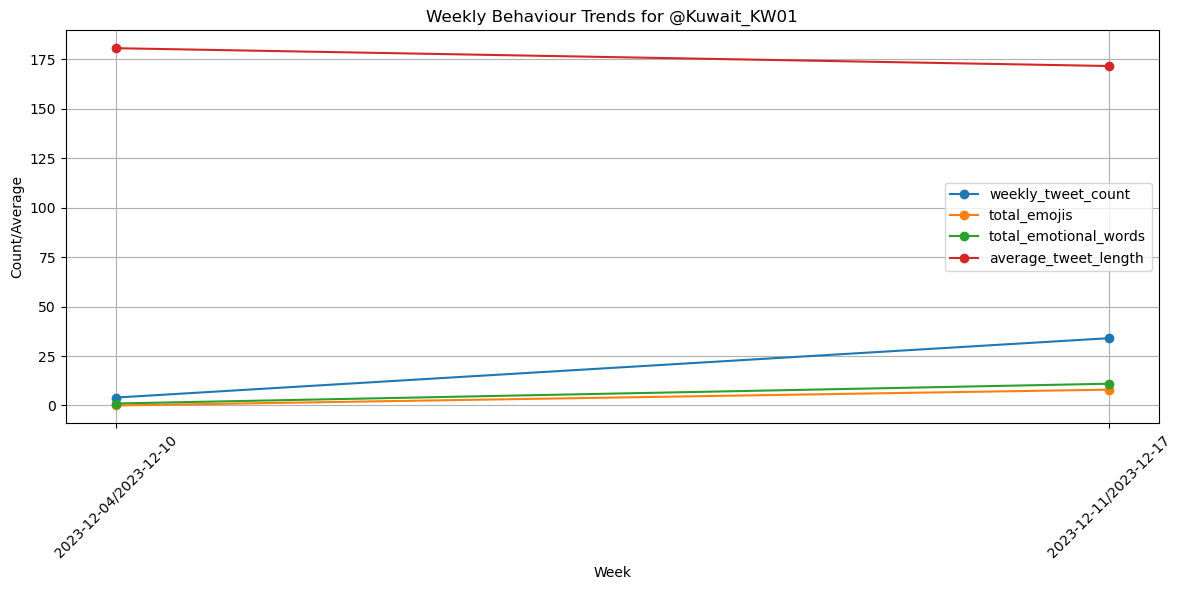

In [674]:
#step 13 - create a line plot to show behavioural changes over weeks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for feature in features_to_plot:
    plt.plot(user_weekly['week'], user_weekly[feature], marker='o', label=feature)

plt.title(f"Weekly Behaviour Trends for @Kuwait_KW01")
plt.xlabel("Week")
plt.ylabel("Count/Average")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

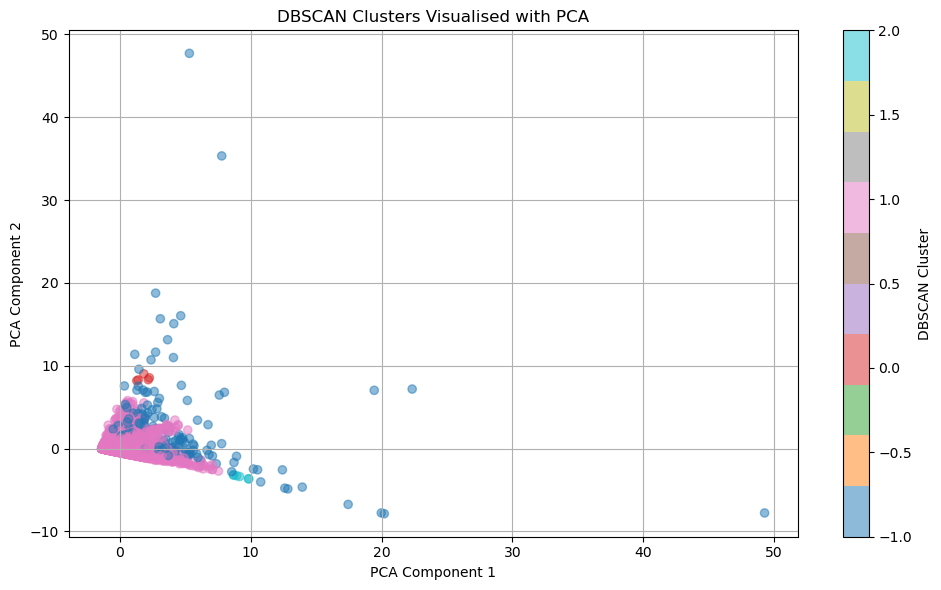

In [675]:
# step 13 again - PCA 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

#create a dataframe for plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = feature_matrix['dbscan_cluster'].values

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['cluster'], cmap='tab10', alpha=0.5)
plt.title('DBSCAN Clusters Visualised with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='DBSCAN Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [676]:
#6. KMeans + DBSCAN combined column to show clusters and outliers
feature_matrix['combined_label'] = feature_matrix.apply(
    lambda row: 'outlier' if row['dbscan_cluster'] == -1 else f"cluster_{row['cluster']}",
    axis=1
)

In [677]:
#step 1 - assigned a combined label to each user
def label_combiner(row):
    if row['dbscan_cluster'] == -1:
        return 'Outlier'
    else:
        return f"Cluster {row['cluster']}" #this is from Kmeans

feature_matrix['combined_label'] = feature_matrix.apply(label_combiner, axis=1)
print(feature_matrix['combined_label'].value_counts())

combined_label
Cluster 0    10290
Cluster 1      158
Outlier        151
Cluster 2       82
Name: count, dtype: int64


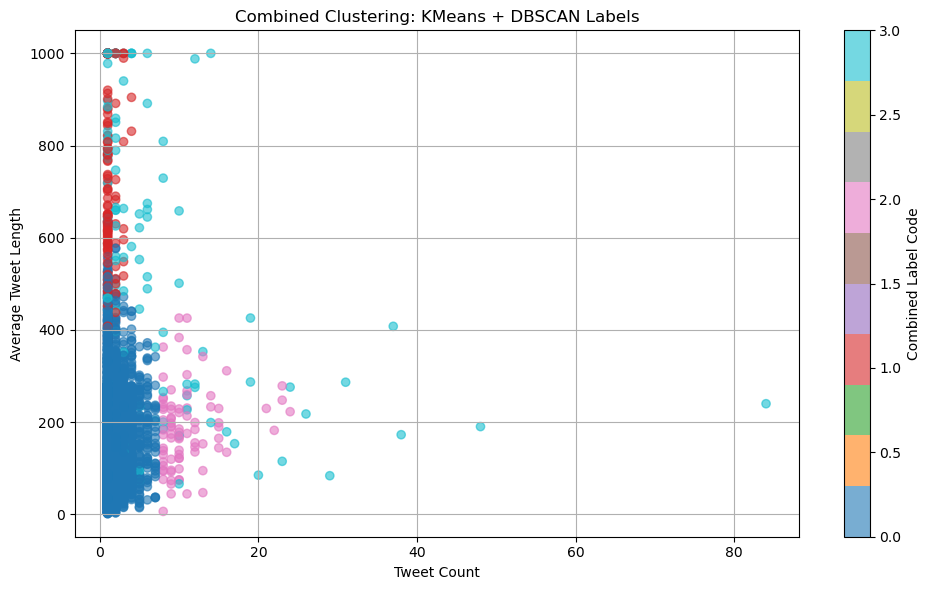

In [678]:
#step 2 - visualise the final labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    feature_matrix['tweet_count'],
    feature_matrix['average_tweet_length'],
    c=feature_matrix['combined_label'].astype('category').cat.codes,
    cmap='tab10',
    alpha=0.6
)

plt.xlabel("Tweet Count")
plt.ylabel("Average Tweet Length")
plt.title("Combined Clustering: KMeans + DBSCAN Labels")
plt.colorbar(scatter, label="Combined Label Code")
plt.grid(True)
plt.tight_layout()
plt.show()

In [679]:
#step 3 - setting up one clear cluster per label
feature_matrix['combined_label'] = feature_matrix.apply(
    lambda row: 'Outlier' if row['dbscan_cluster'] == -1 else f"Cluster {row['cluster']}",
    axis=1
)

In [680]:
#step 4 - show average of behavioural features 
cluster_summary_simple = feature_matrix.groupby('combined_label').mean(numeric_only=True)

In [681]:
#step 5 - preview
print(cluster_summary_simple)

                tweet_count  average_time_between_tweets_minutes  \
combined_label                                                     
Cluster 0          1.312051                           431.635079   
Cluster 1          1.253165                           517.726793   
Cluster 2         11.036585                          1606.685942   
Outlier            5.920530                         17300.307399   

                percentage_of_tweets_with_all_caps  \
combined_label                                       
Cluster 0                                      0.0   
Cluster 1                                      0.0   
Cluster 2                                      0.0   
Outlier                                        0.0   

                average_emoji_count_per_tweet  \
combined_label                                  
Cluster 0                            0.211410   
Cluster 1                            0.227848   
Cluster 2                            0.320127   
Outlier              

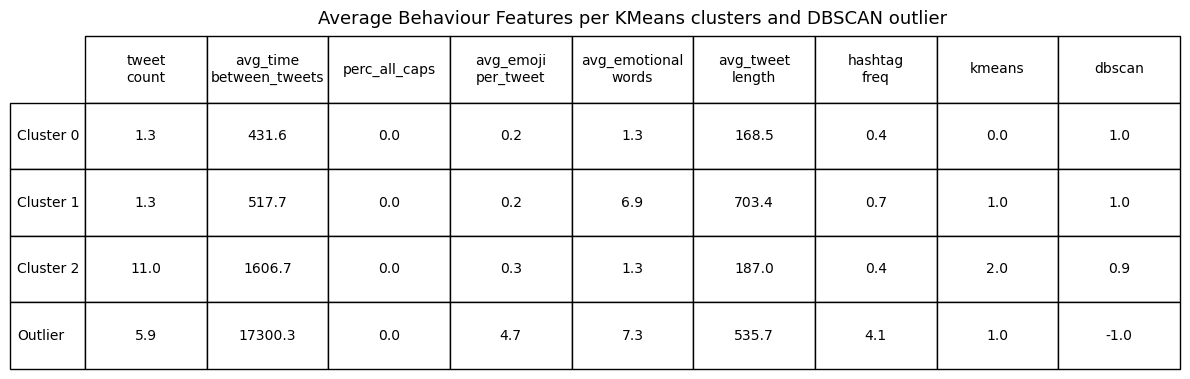

In [682]:
#step 6 - turn the data into a readable table to observe the differences between clusters
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off') 

#clean headers for readability
wrapped_columns = [
    'tweet\ncount',
    'avg_time\nbetween_tweets',
    'perc_all_caps',
    'avg_emoji\nper_tweet',
    'avg_emotional\nwords',
    'avg_tweet\nlength',
    'hashtag\nfreq',
    'kmeans',
    'dbscan'
]

table = ax.table(
    cellText=rounded_summary.values,
    colLabels=wrapped_cols,
    rowLabels=rounded_summary.index,
    cellLoc='center',
    loc='center'
)

table.scale(1, 5)
table.auto_set_font_size(False)
table.set_fontsize(10)#optimal font size

plt.title("Average Behaviour Features per KMeans clusters and DBSCAN outlier", fontsize=13, pad=40)#padding adjusted to fit text above the table
plt.tight_layout()
plt.show()

In [683]:
#it appears that there are some notable differences in each clusters:
#cluster 0 seems to be the least significant out of all, as these users rarely tweet and when they do, they do not use emotional language or emoji
#cluster 1 seem to write rich, long, emotional tweets
#cluster 2 seem to tweet more than any other group
#outliers seems to be extremely irregular - delays between tweets, very emotional with high amount of emoji and hashtags,
#         not following any pattern in particular

In [684]:
#step 7 - renaming clusters to their observed behaviours
#cluster 0: Neutral Users
#cluster 1: Emotional Writers
#Cluster 2: Heavy Posters
#Outlier: Irregular Spammers

#rename clusters in code
def rename_cluster(row):
    if row['combined_label'] == 'Outlier':
        return 'Irregular Spammers'
    elif row['cluster'] == 0:
        return 'Neutral Users'
    elif row['cluster'] == 1:
        return 'Emotional Writers'
    elif row['cluster'] == 2:
        return 'Heavy Posters'
    else:
        return 'Unknown'

feature_matrix['cluster_name'] = feature_matrix.apply(rename_cluster, axis=1)

In [685]:
#step 8 - preview these changes
print(feature_matrix[['cluster', 'dbscan_cluster', 'combined_label', 'cluster_name']].drop_duplicates())

                 cluster  dbscan_cluster combined_label        cluster_name
username                                                                   
Novytique              2              -1        Outlier  Irregular Spammers
narendra483            2               0      Cluster 2       Heavy Posters
Argos_Reed             2               1      Cluster 2       Heavy Posters
MorHogeg               1              -1        Outlier  Irregular Spammers
neveenalgundor         0               1      Cluster 0       Neutral Users
NewsNationTV           0              -1        Outlier  Irregular Spammers
TheInsiderPaper        1               1      Cluster 1   Emotional Writers
Dana35300026           1               2      Cluster 1   Emotional Writers


In [686]:
#step 9 - test - automatically find an user with the most emotional words posted and show their timeline
emotional_users = feature_matrix[feature_matrix['cluster_name'] == 'Irregular Spammers'].index
emotional_users = weekly_metrics[weekly_metrics['username'].isin(emotional_users)]
user_with_most_weeks = emotional_weeks['username'].value_counts().idxmax()

In [687]:
#step 10 - filter the user's weekly timeline
user_weekly = weekly_metrics[weekly_metrics['username'] == user_with_most_weeks].sort_values('week')

In [688]:
#step 11 - features to track
features_to_plot = [
    'total_emotional_words'
]

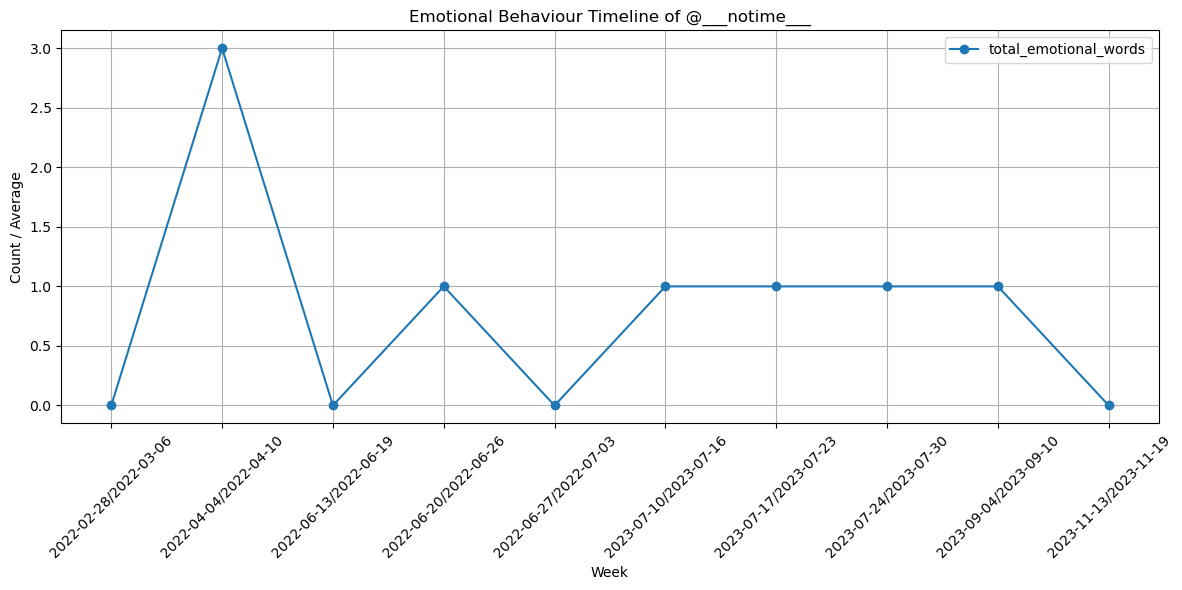

In [689]:
#step 12 - plot the weekly behaviour
plt.figure(figsize=(12, 6))
for feature in features_to_plot:
    plt.plot(user_weekly['week'], user_weekly[feature], marker='o', label=feature)

plt.title(f"Emotional Behaviour Timeline of @{user_with_most_weeks}")
plt.xlabel("Week")
plt.ylabel("Count / Average")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [690]:
#step 13 - 